# Решение задачи:

Выполним ряд установок, а именно:
1. Установим репозиторий с стабильной версией **MuseScore 3** - бесплатный нотный редактор;
2. `fluidsynth` -  это программный синтезатор звука, который преобразует *MIDI-данные* в аудио;
3. `pyfluidsynth` - это *Python-обёртка* (интерфейс) для библиотеки *FluidSynth*, позволяющая управлять синтезатором из Python-кода;
4. `Music21` — это открытый инструментарий на основе Python для вычислительной музыкологии;
5. `pretty_midi` — библиотека на языке Python для создания, управления и анализа файлов MIDI.

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!apt-get install musescore3
!pip install music21 pretty_midi tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

Настраиваем окружение в соответствии с документацией и устанавливаем необходимые библиотеки:

In [ ]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore3'
us['directoryScratch'] = '/tmp'

import os
import numpy as np
import pandas as pd
from collections import Counter
import pretty_midi
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from music21 import note, tempo
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

Установим необходимый датасет и напишем функцию для загрузки произведений конкретных авторов:

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
!unzip -qo "classical-music-midi" -d ./dataset

#загрузка произведений Шопена и Моцарта
def load_midi(folder):
    return [converter.parse(f"./dataset/{folder}/{f}") for f in os.listdir(f"./dataset/{folder}") if f.endswith(".mid")]

chopin_midis = load_midi("Chopin")
mozart_midis = load_midi("Mozart")[:1] #только 1 файл Моцарта

--2025-06-15 07:20:29--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  1.90MB/s    in 1.4s    

2025-06-15 07:20:31 (1.90 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]



Создадим функцию для извлечения параметров.

`prev_offset` — временная метка предыдущей ноты.

`n.offset` — это временная метка ноты в произведении (в четвертях).

In [ ]:
def get_notes_data_music21(midi_files):
    all_notes = []
    #принимает список MIDI-файлов в формате music21
    for i, score in enumerate(midi_files):
        #print(f"Обработка файла {i+1}/{len(midi_files)} через music21...")
        try:
            notes = score.flat.notes #извлекает ноты
            prev_offset = None
            #проходит по каждой ноте и извлекает параметры
            for n in notes:
                if hasattr(n, 'pitch') and n.isNote:
                    pitch = n.pitch.midi
                    duration = n.duration.quarterLength
                    step = n.offset - (prev_offset or n.offset)
                    step = max(0.01, abs(step)) #минимальный шаг, чтобы избежать нуля и ошибок
                    prev_offset = n.offset
                    all_notes.append({
                        'pitch': pitch,
                        'step': step,
                        'duration': max(0.05, duration) #минимальная длительность для стабильности
                    })
        except Exception as e:
            print(f"Ошибка при обработке файла {i}: {e}")
    return pd.DataFrame(all_notes)

Воспользуемся только что созданной функцией:

In [ ]:
chopin_notes = get_notes_data_music21(chopin_midis)
mozart_notes = get_notes_data_music21(mozart_midis)

Проверим, что в наших данных есть нужные колонки, а именно:

`pitch` — высота ноты;

`step` — время между нотами;

`duration` — длительность звучания ноты.

Далее выполним нормализацию данных, используя `MinMaxScaler()`:

In [ ]:
#проверка, что данные загружены
required_cols = ['pitch', 'step', 'duration']
for df in [chopin_notes, mozart_notes]:
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"В данных отсутствуют колонки: {missing}")

#нормализация данных
scaler = MinMaxScaler()
chopin_notes[['pitch_norm', 'step_norm', 'duration_norm']] = scaler.fit_transform(
    chopin_notes[['pitch', 'step', 'duration']]
)
mozart_notes[['pitch_norm', 'step_norm', 'duration_norm']] = scaler.transform(
    mozart_notes[['pitch', 'step', 'duration']]
)

Выполним анализ уже убработанных данных и удалим ненужные из них:

In [ ]:
#подсчёт частоты встречаемости высоты нот
pitch_list = chopin_notes['pitch'].astype(int).astype(str).tolist()
pitch_counts = Counter(pitch_list)

#поиск редких высот (встречаются менее 100 раз)
rare_pitches = [int(p) for p, c in pitch_counts.items() if c < 100]
print(f"Число редких высот (повторяются <100 раз): {len(rare_pitches)}")

#удаление редких нот
chopin_notes_filtered = chopin_notes[~chopin_notes['pitch'].isin(rare_pitches)]
print(f"Длина корпуса после очистки: {len(chopin_notes_filtered)}")

Число редких высот (повторяются <100 раз): 21
Длина корпуса после очистки: 35752


Выполним финальную подготовку данных для обучения модели:

In [ ]:
sequence_length = 40 #установим последовательность из 40 нот
X, y = [], []

for i in range(len(chopin_notes_filtered) - sequence_length):
    seq = chopin_notes_filtered[['pitch_norm', 'step_norm', 'duration_norm']].iloc[i:i+sequence_length].values #срез из 40 нот
    target = chopin_notes_filtered[['pitch_norm', 'step_norm', 'duration_norm']].iloc[i+sequence_length].values #срез из 40 нот
    X.append(seq)
    y.append(target)

X = np.array(X)
y = np.array(y)
print(f"Форма данных: X ={ X.shape}, y = {y.shape}") #проверим результат работы кода

Форма данных: X =(35712, 40, 3), y = (35712, 3)


Выполним настройку архитектуры модели, её компиляцию, обучение и вывод подробной информации о ней:

In [ ]:
model = Sequential([
    LSTM(256, input_shape=(sequence_length, 3), return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X, y, batch_size=256, epochs=50, validation_split=0.2, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 256)        │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,811 (1.80 MB)

 Trainable params: 471,811 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0213 - val_loss: 0.0082
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0105 - val_loss: 0.0084
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0095 - val_loss: 0.0079
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 12/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 

Выведем график обучения:

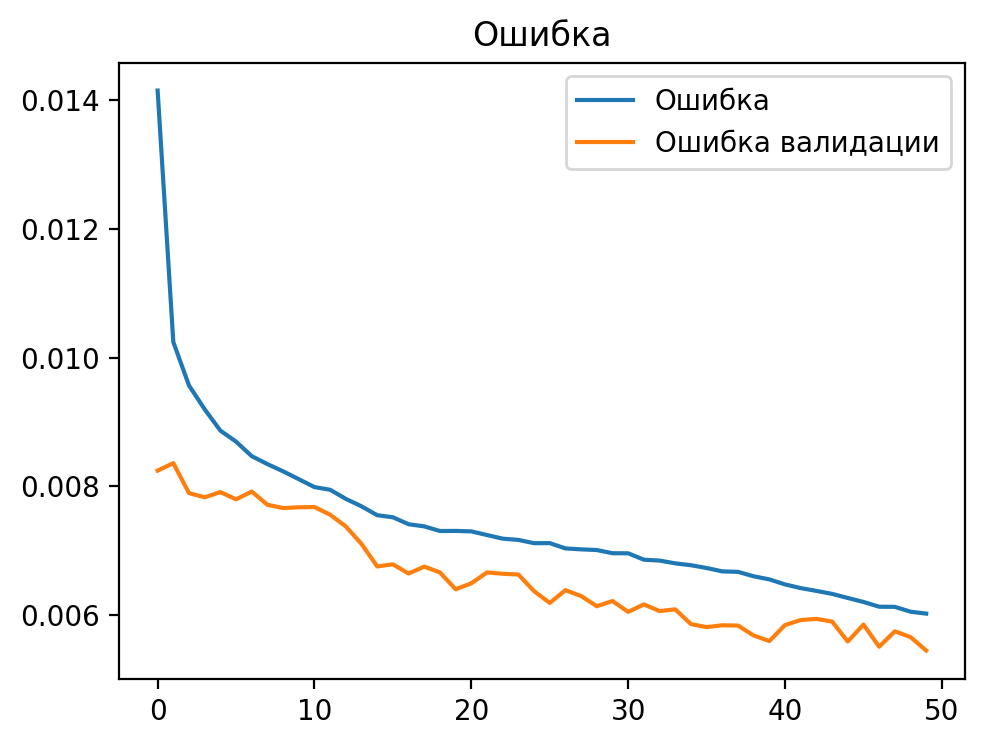

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Ошибка')
plt.plot(history.history['val_loss'], label='Ошибка валидации')
plt.legend()
plt.title("Ошибка");

Проверяем, достаточно ли нот Моцарта для начальной последовательности. Создадим начальную последовательность из первых `sequence_length` нот Моцарта:

In [ ]:
#проверка длины начальной последовательности
if len(mozart_notes) < sequence_length:
    raise ValueError(f"Нужно минимум {sequence_length} нот Моцарта, а доступно только {len(mozart_notes)}")

#берем первые sequence_length нот Моцарта
mozart_seq = mozart_notes[['pitch_norm', 'step_norm', 'duration_norm']].values[:sequence_length]
print(f"Создана начальная последовательность из {len(mozart_seq)} нот Моцарта")

Создана начальная последовательность из 40 нот Моцарта


Эта функция реализует генерацию музыки на основе модели, обученной предсказывать параметры нот: *pitch, step, duration*. Она генерирует последовательность нот , начиная с заданной начальной последовательности (`seed`), используя обученную модель и добавляя случайность через температуру (`temp`):

In [ ]:
def generate_music(seed, steps=300, temp=0.7):
    music = []
    current_seq = seed.copy()

    for _ in range(steps):
        pred = model.predict(current_seq.reshape(1, sequence_length, 3), verbose=0)[0]

        pred = np.clip(pred + np.random.normal(0, temp * 0.3), 0, 1) #применение температуры

        #денормализация значений
        pitch = int(scaler.inverse_transform([pred])[0][0])
        step = max(0.1, scaler.inverse_transform([pred])[0][1])
        duration = max(0.25, min(4.0, scaler.inverse_transform([pred])[0][2]))

        #создание ноты
        music.append(pitch)
        current_seq = np.roll(current_seq, -1, axis=0) #сдвигает все ноты влево на одну
        current_seq[-1] = pred #добавляет новое предсказание в конец последовательности
        #таким образом, модель всегда работает с последними 40 нотами

    return music

Следующая функция преобразует список в последовательность `note.Note`, которую можно отобразить как ноты или проигрыватель:

In [ ]:
def chords_n_notes(pitch_list):
    Melody = []
    offset = 0
    for pitch in pitch_list:
        n = note.Note(int(pitch)) #cоздаёт объект ноты из библиотеки music21 на основе MIDI-номера
        n.offset = offset #создает временную позицию этой ноты в потоке
        Melody.append(n)
        offset += 1
    return stream.Stream(Melody) #это "контейнер" в music21, куда мы добавляем ноты, аккорды

Финальная часть кода - отображение нот и плеера:

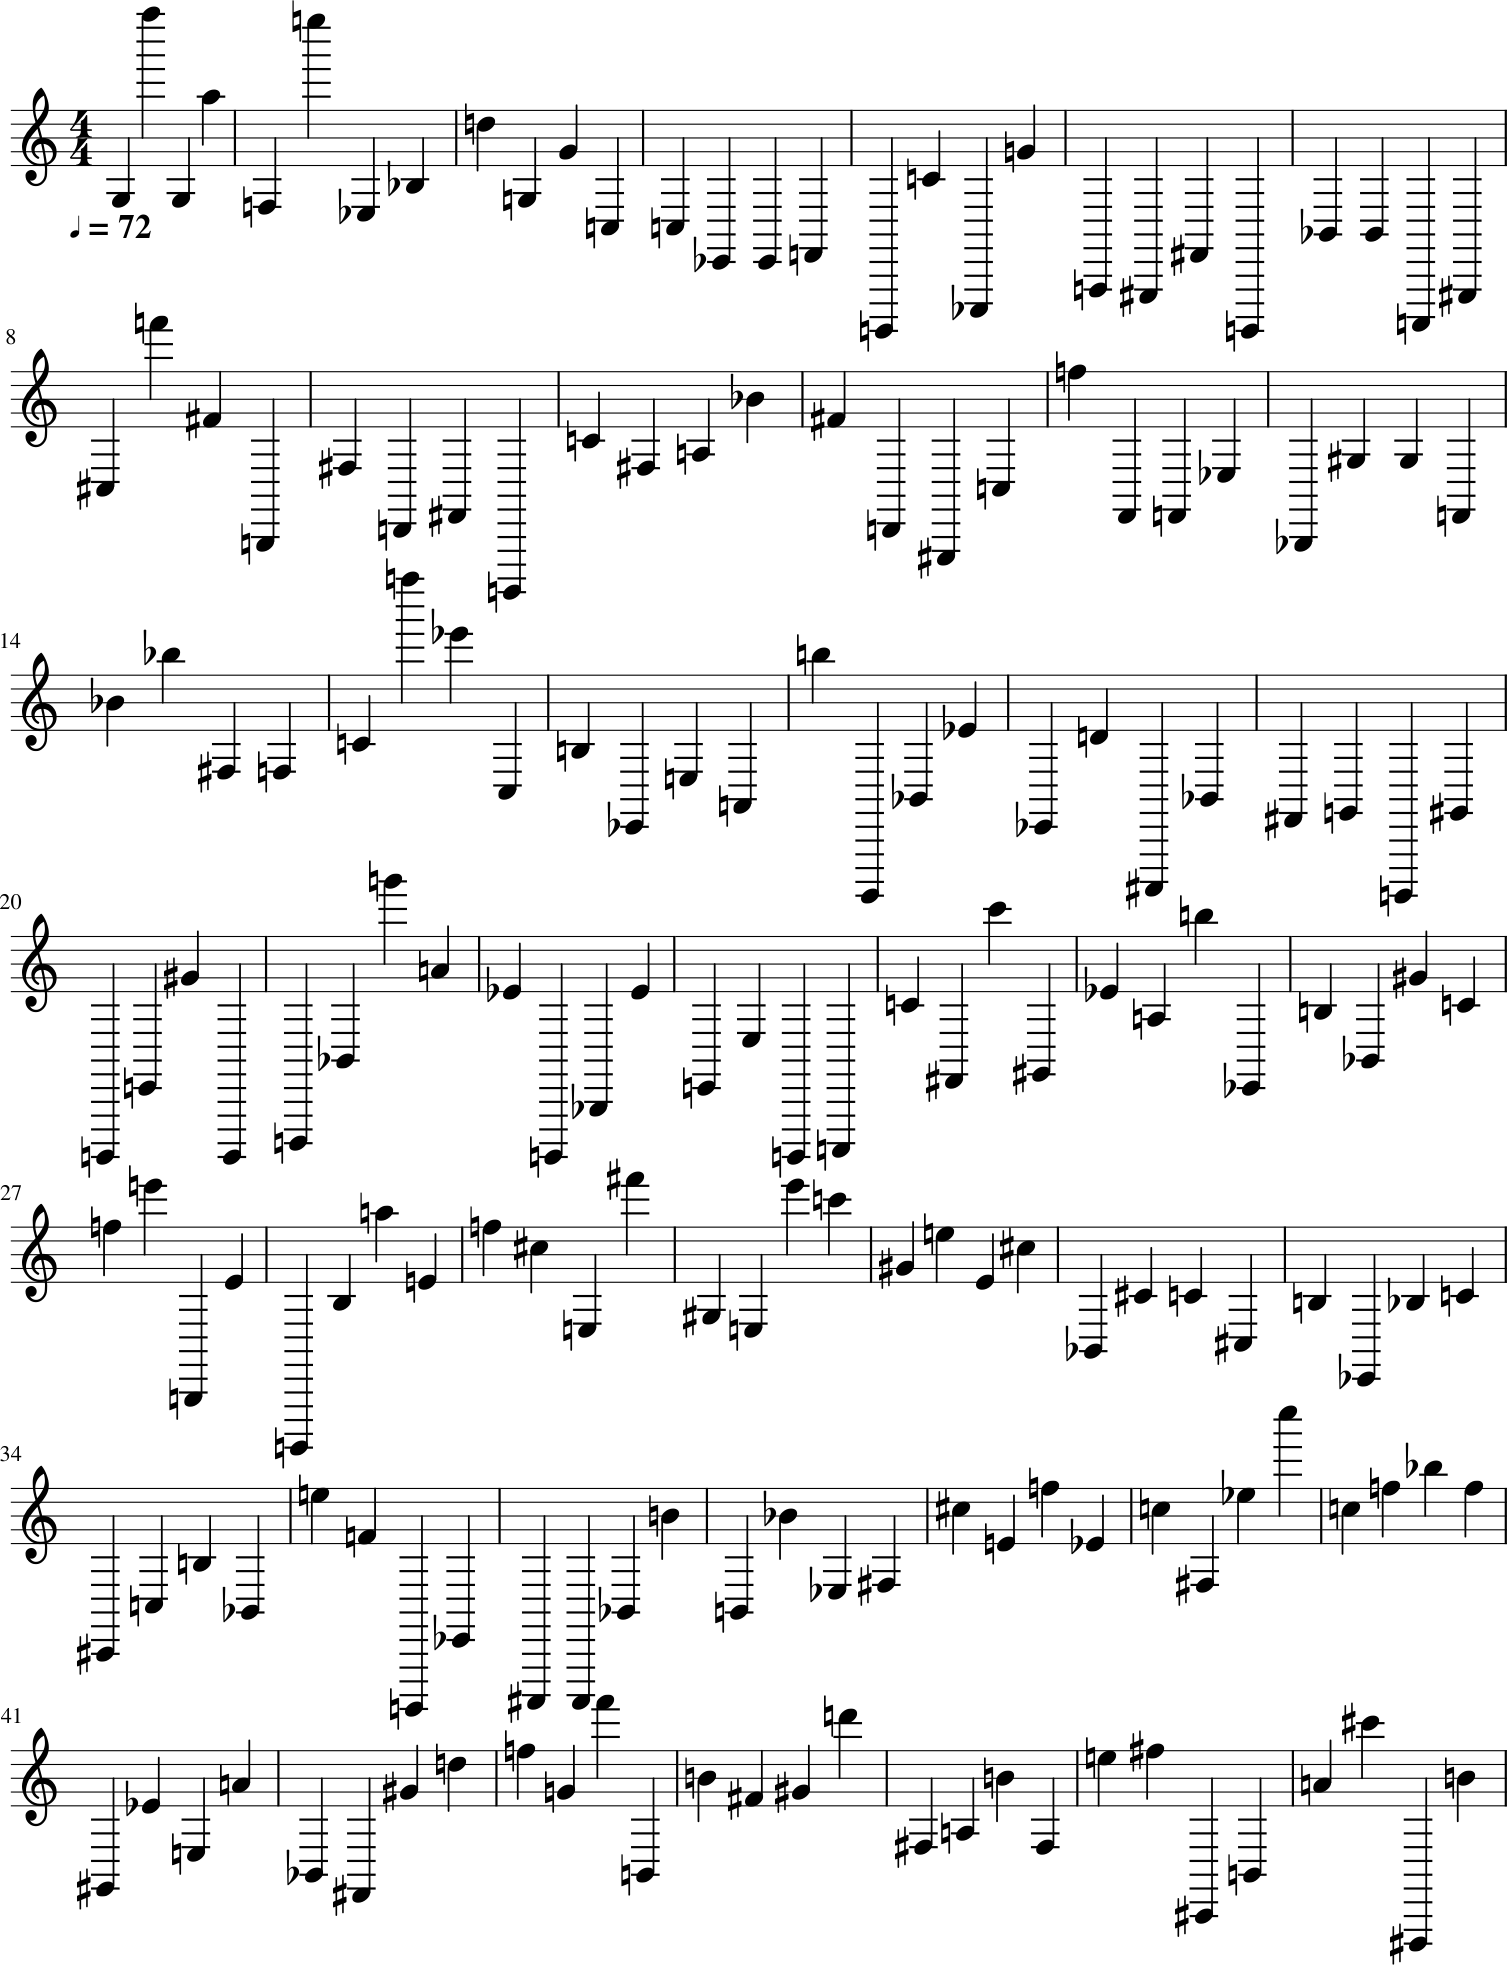

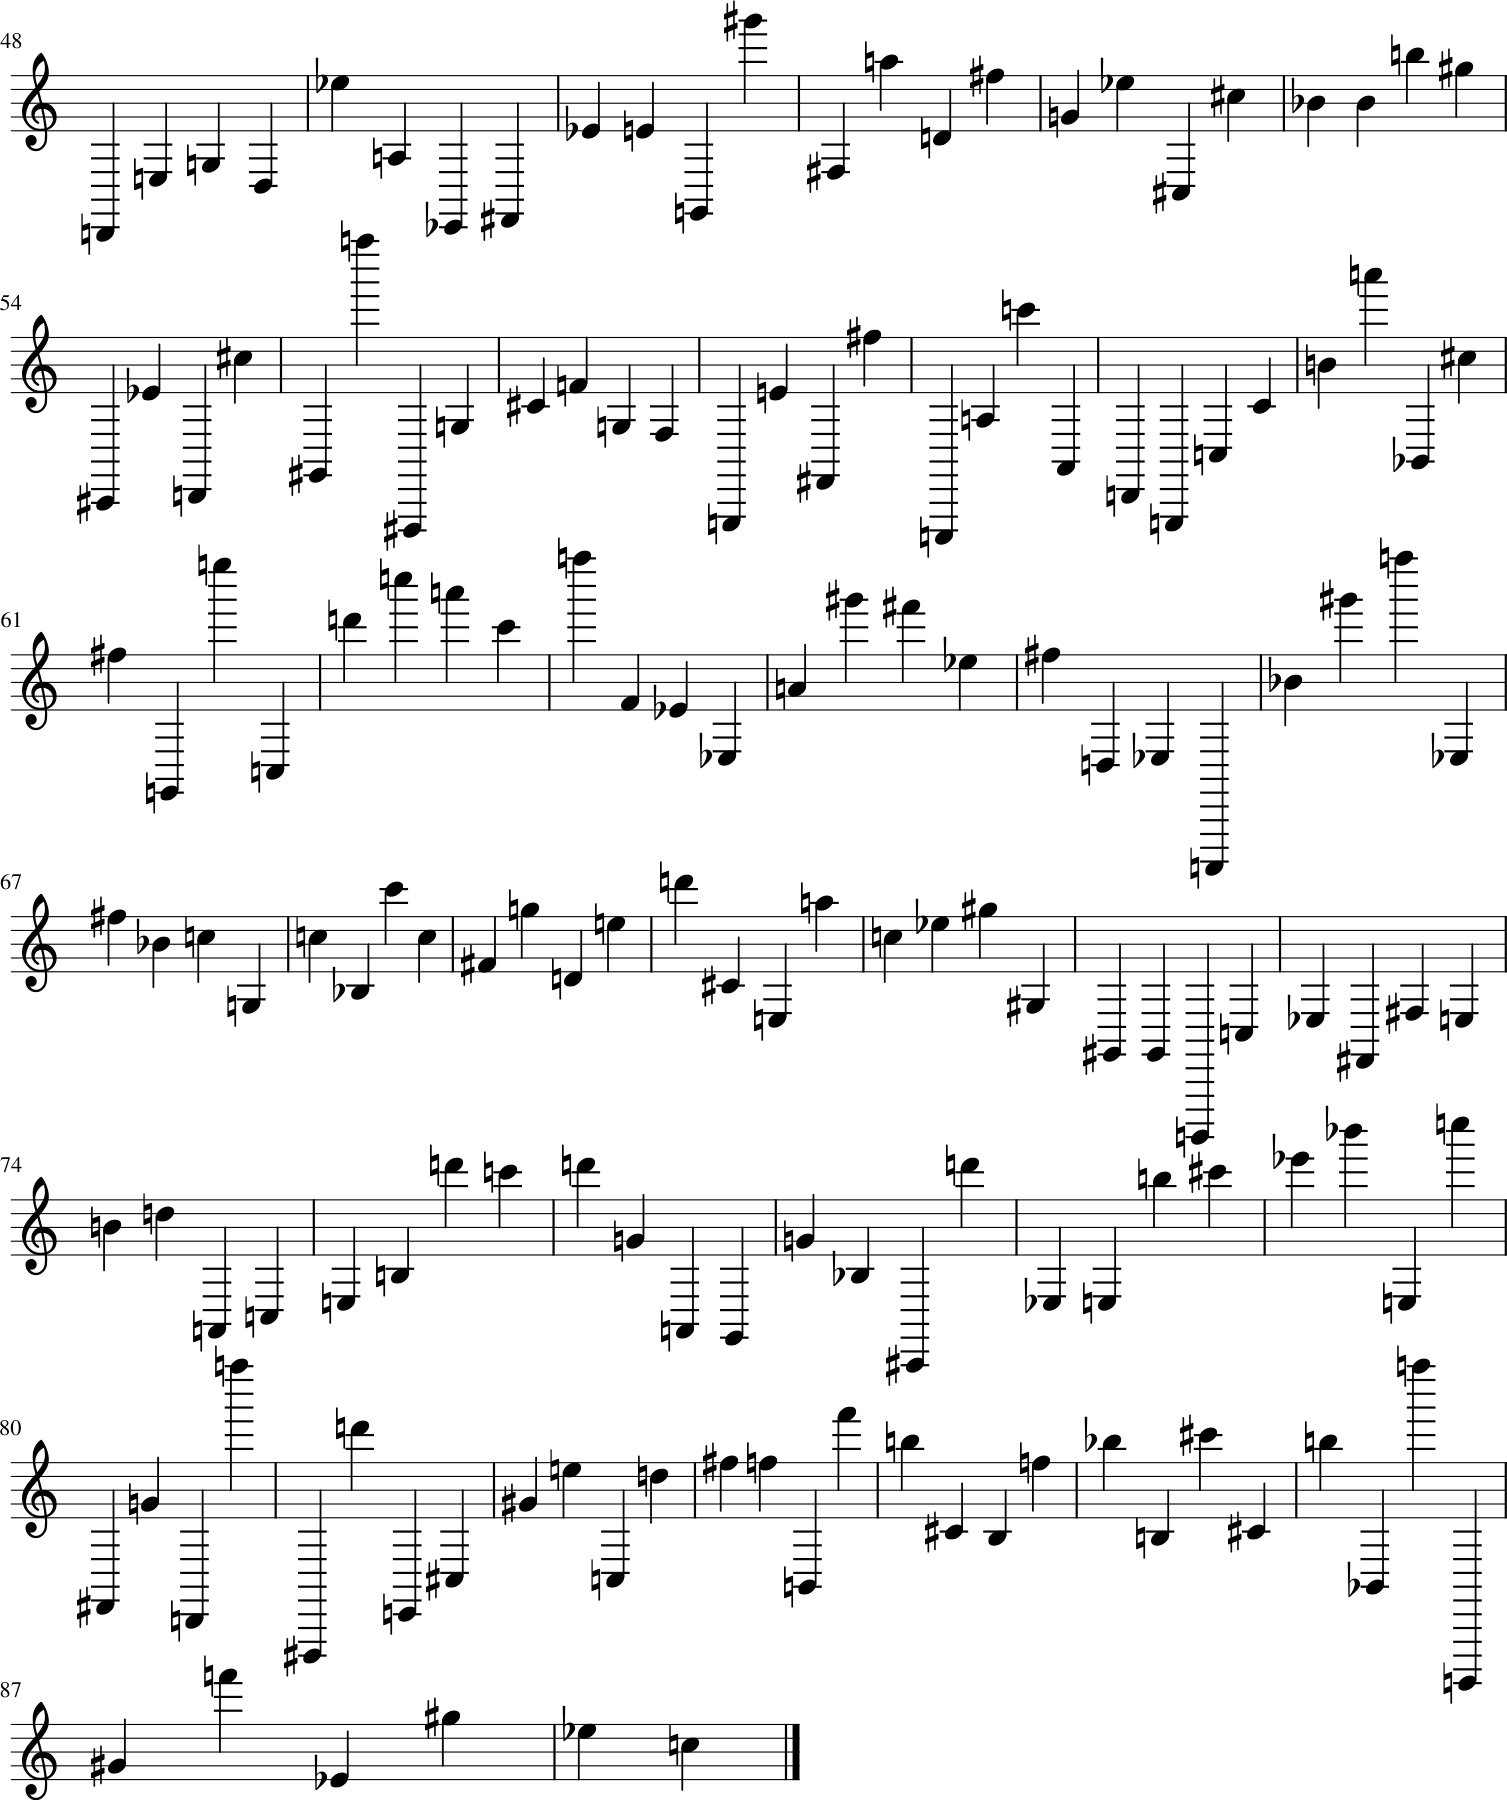

In [ ]:
generated_pitches = generate_music(mozart_seq, steps=350, temp=0.8)
generated_stream = chords_n_notes(generated_pitches)
generated_stream.insert(0, tempo.MetronomeMark(number=72)) #управляем темпом


generated_stream.show(); #отображение нот
generated_stream.show('midi'); #плеер